In [1]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

In [2]:
%matplotlib inline

In [3]:
rcParams['figure.figsize'] = 12, 9

In [4]:
import astroimsim

In [5]:
zl = astroimsim.ZodiacalLight()

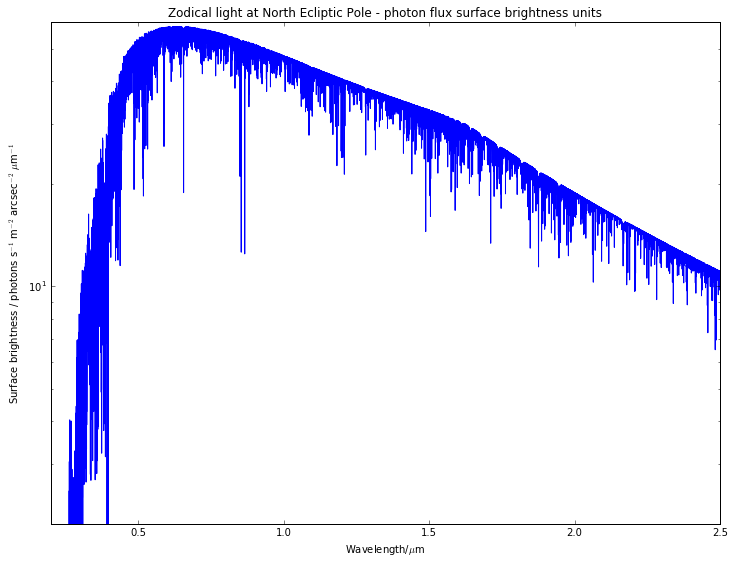

In [6]:
plt.semilogy(zl.waves, zl.photon_sfd, label='Zodical Light - NEP')
plt.xlim(0.2,2.5)
plt.ylim(2e-0,6e1)
plt.xlabel('Wavelength/$\mu$m')
plt.ylabel('Surface brightness / photons s$^{-1}$ m$^{-2}$ arcsec$^{-2}$ $\mu$m$^{-1}$')
plt.title('Zodical light at North Ecliptic Pole - photon flux surface brightness units');